# Niyati's Sleep Analysis
Niyati's sleep data from Feb, 1 to May, 31 as collected by her Fitbit  

**Objectives**: 
1. Gain insight into Niyati's Sleeping patterns
2. Learn to use and implement python's statistical tools

Questions I'm trying to answer:
* General data collection. 
    1. How long does she normally sleep? 
    2. When does she go to bed? etc.

* Getting more insight.
    1. Using the collected data, can we speculate what the ideal sleep period can be?
    2. What should be the ideal bedtime?

* Sleep Stages.
    1. How does the amount of sleep affect the quality of sleep?

In [27]:
#import relevant librabries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup as bs
import seaborn as sns
import datetime as dt
from matplotlib import gridspec
from matplotlib import dates
from scipy.stats import linregress
from scipy import stats

In [28]:
sleep=pd.read_csv('niyatisleep.csv',header=0)
sleep=sleep.dropna(axis=0, how='any')
print(sleep.shape)
sleep.keys()

(105, 9)


Index(['Start Time', 'End Time', 'Minutes Asleep', 'Minutes Awake',
       'Number of Awakenings', 'Time in Bed', 'Minutes REM Sleep',
       'Minutes Light Sleep', 'Minutes Deep Sleep'],
      dtype='object')

## Data imported from Fitbit:
``` python 
['Start Time', 'End Time', 'Minutes Asleep', 'Minutes Awake','Number of Awakenings',
 'Time in Bed', 'Minutes REM Sleep','Minutes Light Sleep', 'Minutes Deep Sleep']
```

However, this data needs to be cleaned before we can apply some features.

Here we convert the timestamps into python's datetime objects, sort the data chronologically, define days of the week and assign a timecode to sleep time and wake time.

In [29]:
# Convert Start time and End time into python compatible datetime entries
sleep['Start Time']=[dt.datetime.strptime(sleep.loc[i,'Start Time'],'%Y-%m-%d %I:%M%p') for i in sleep.index]
sleep['End Time']=[dt.datetime.strptime(sleep.loc[i,'End Time'],'%Y-%m-%d %I:%M%p') for i in sleep.index]
#chronological sort
sleep=sleep.sort_values(by='Start Time')
#Define Days of the week
sleep['Day']=[sleep.loc[i,'End Time'].strftime('%A') for i in sleep.index]
#Adding time objects
sleep['Sleep Time']=[sleep.loc[i,'Start Time'].time() for i in sleep.index]
sleep['Wake Time']=[sleep.loc[i,'End Time'].time() for i in sleep.index]

### A sample of the data available from Fitbit and additional data extracted for analysis

In [30]:
sleep.head(5)

,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Day,Sleep Time,Wake Time
28,2018-02-01 00:15:00,2018-02-01 07:29:00,376,58,26,434,115.0,159.0,102.0,Thursday,00:15:00,07:29:00
27,2018-02-02 00:36:00,2018-02-02 07:02:00,323,63,25,386,36.0,229.0,58.0,Friday,00:36:00,07:02:00
26,2018-02-03 00:36:00,2018-02-03 08:33:00,434,43,21,477,96.0,253.0,85.0,Saturday,00:36:00,08:33:00
25,2018-02-04 01:42:00,2018-02-04 09:12:00,378,72,26,450,109.0,199.0,70.0,Sunday,01:42:00,09:12:00
24,2018-02-04 23:05:00,2018-02-05 07:06:00,428,53,28,481,121.0,190.0,117.0,Monday,23:05:00,07:06:00


In [31]:
daymean=sleep.groupby(['Day']).mean()['Minutes Asleep']
daymedian=sleep.groupby(['Day']).median()['Minutes Asleep']
daydev=sleep.groupby(['Day']).std()['Minutes Asleep']

## Sleep according to the day of the week

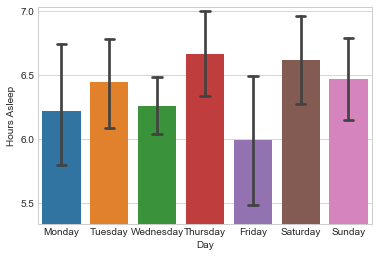

In [32]:
sns.set_style("whitegrid")
daysorder=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax = sns.barplot(x='Day',y='Minutes Asleep',capsize=0.2,order=daysorder,data=sleep)
axis=ax.axes
axis.set_ylim(320,422)
hourticks=np.array([330+30*i for i in range(4)])
axis.set_yticks(hourticks)
axis.set_yticklabels(hourticks/60)
axis.set_ylabel('Hours Asleep')
plt.savefig('daysleep.png', bbox_inches='tight')

![daysleep](daysleep.png)
<center>There is no significant predictable variation in hours asleep depending on the day of the week. The lack of a 9-5 work schedule is primarily resposible for the lack of the typical sleeping pattern of less sleep during weekdays and more during weeekends. Median hours Asleep fall in a tight 30 minute window</center>

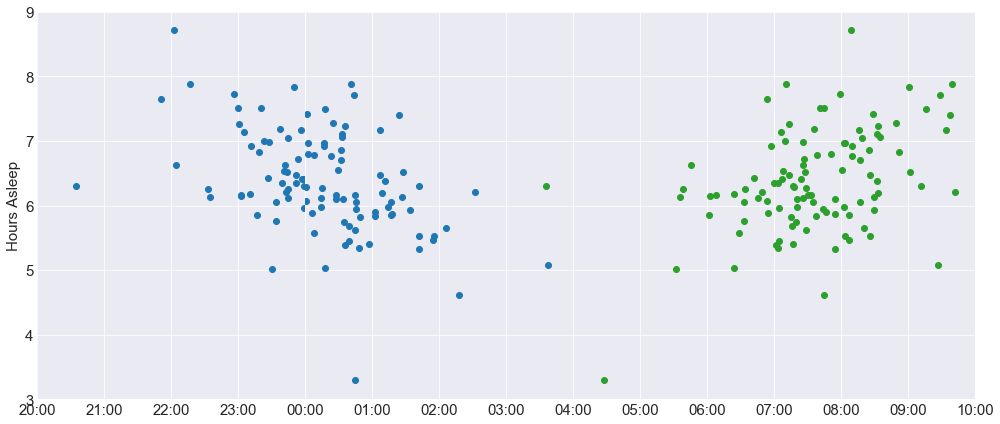

In [34]:
f=plt.figure(figsize=(14,6))
sns.set_style("darkgrid")
gs = gridspec.GridSpec(1,2,wspace=0.0, width_ratios=[4, 10]) 
ax= plt.subplot(gs[0,0])
ax.scatter(list(sleep['Sleep Time']),sleep['Minutes Asleep']/60,color='tab:blue')
ax.set_xlim([dt.time(20, 0), dt.time(23,59,59)])
ax.set_xticks([dt.time.strftime(dt.time(i, 0),'%H:%M') for i in range(20,24)])
ax.set_xticklabels([dt.time.strftime(dt.time(i, 0),'%H:%M') for i in range(20,24)])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim([3,9])
plt.xlabel('')
ax.set_ylabel('Hours Asleep', fontsize=15)
ax2=plt.subplot(gs[0,1])
ax2.scatter(list(sleep['Sleep Time']),sleep['Minutes Asleep']/60,color='tab:blue')
ax2.scatter(list(sleep['Wake Time']),sleep['Minutes Asleep']/60,color='tab:green')
ax2.set_xlim([dt.time(0, 0), dt.time(10,0)])
ax2.set_ylim([3,9])
ax2.set_xticks([dt.time(i, 0) for i in range(11)])
ax2.set_xticklabels([dt.time.strftime(dt.time(i, 0),'%H:%M') for i in range(11)])
ax2.set_yticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('')
plt.tight_layout()
plt.savefig('hoursawake.png', bbox_inches='tight')

## Bedtime and Waketime distribution
![hoursawake](hoursawake.png)
<center>There seems to be a clear inverse relationship between the bedtime and hours asleep. The earlier you sleep, you end up actually sleeping more than you usually would. The ideal bedtime window lies between 11PM and 1AM, which will most likely end up providing the necessary 6-7 hours of sleep.</center>

In [159]:
time=pd.DataFrame()
time['Hours Asleep']=sleep['Minutes Asleep']/60
time['Sleep Time']=sleep['Sleep Time']
time['minutes']=0
for i in time.index:
    time.loc[i,'minutes']=time.loc[i,'Sleep Time'].hour*60+time.loc[i,'Sleep Time'].minute
    if time.loc[i,'minutes']>1000:
        time.loc[i,'minutes']=time.loc[i,'minutes']-24*60

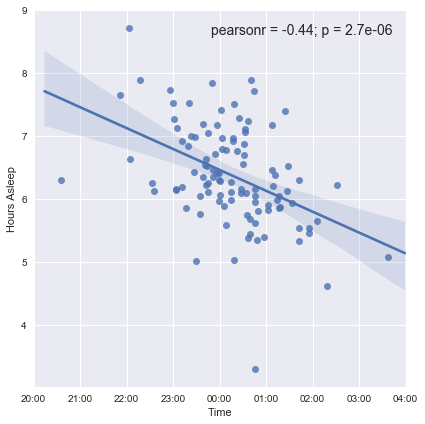

In [161]:
sns.set_style("darkgrid")
g = sns.JointGrid(x="minutes", y="Hours Asleep", data=time, ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr,fontsize=14)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()
plt.xticks([-240,-180,-120,-60,0,60,120,180,240]);
g.set_axis_labels('Time', 'Hours Asleep')
g.ax_joint.set_xticklabels([dt.time.strftime(dt.time(i, 0),'%H:%M') for i in range(20,24)]+
                           [dt.time.strftime(dt.time(i, 0),'%H:%M') for i in range(5)]);

In [162]:
stage=pd.DataFrame()
stage['REM']=sleep['Minutes REM Sleep']/sleep['Time in Bed']*100
stage['Light']=sleep['Minutes Light Sleep']/sleep['Time in Bed']*100
stage['Deep']=sleep['Minutes Deep Sleep']/sleep['Time in Bed']*100
stage['Awake']=sleep['Minutes Awake']/sleep['Time in Bed']*100
stage['Quality']='fair'
for i in stage.index:
    if sleep.loc[i,'Minutes Asleep']/60<=6:
        stage.loc[i,'Quality']='less'
    elif sleep.loc[i,'Minutes Asleep']/60>7:
        stage.loc[i,'Quality']='more'

In [163]:
stage1=pd.DataFrame()
stage1['Value']=stage['REM']
stage1['Stage']='REM'
stage1['Quality']=stage['Quality']
stage2=pd.DataFrame()
stage2['Value']=stage['Light']
stage2['Quality']=stage['Quality']
stage2['Stage']='Light'
stage3=pd.DataFrame()
stage3['Value']=stage['Deep']
stage3['Quality']=stage['Quality']
stage3['Stage']='Deep'
stage4=pd.DataFrame()
stage4['Value']=stage['Awake']
stage4['Quality']=stage['Quality']
stage4['Stage']='Awake'
stageall=pd.concat([stage1,stage2,stage3,stage4],ignore_index=True)

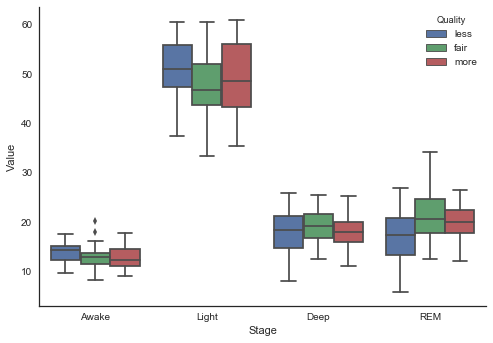

In [164]:
sns.set(style="white")
sns.boxplot(x='Stage', y='Value',hue='Quality',order=['Awake','Light','Deep','REM'],
            hue_order=['less', 'fair', 'more'], data=stageall)
sns.despine()